In [ ]:
# default_exp core.nn.optim.lr_schedulers

In [ ]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [ ]:
# hide
from nbdev.export import *
from nbdev.imports import Config as NbdevConfig
from nbdev.showdoc import *

nbdev_path = NbdevConfig().path("nbs_path")

# Learning Rate Schedules
> LRSchedulers to scheduler learning rate

In [ ]:
# export
from typing import *

import torch
from fvcore.common.param_scheduler import *
from torch.optim import Optimizer
from torch.optim.lr_scheduler import (
    CosineAnnealingWarmRestarts,
    MultiStepLR,
    OneCycleLR,
    ReduceLROnPlateau,
    StepLR,
)

In [ ]:
from gale.core.nn.optim.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
# export
_all_ = ["CosineAnnealingWarmRestarts", "MultiStepLR", "OneCycleLR", "ReduceLROnPlateau", "StepLR"]

In [ ]:
# export
class LRMultiplier(torch.optim.lr_scheduler._LRScheduler):
    """
    A LRScheduler which uses fvcore  `ParamScheduler` to multiply the
    learning rate of each param in the optimizer.
    Every step, the learning rate of each parameter becomes its initial value
    multiplied by the output of the given `ParamScheduler`.
    The absolute learning rate value of each parameter can be different.
    This scheduler can be used as long as the relative scale among them do
    not change during training.

    Source: https://github.com/facebookresearch/detectron2/blob/master/detectron2/solver/lr_scheduler.py
    """

    # NOTES: in the most general case, every LR can use its own scheduler.
    # Supporting this requires interaction with the optimizer when its parameter
    # group is initialized. For example, classyvision implements its own optimizer
    # that allows different schedulers for every parameter group.
    # To avoid this complexity, we use this class to support the most common cases
    # where the relative scale among all LRs stay unchanged during training.  In this
    # case we only need a total of one scheduler that defines the relative LR multiplier.

    def __init__(
        self,
        optimizer: Optimizer,
        multiplier: ParamScheduler,
        max_iter: int,
        last_iter: int = -1,
    ):
        """
        Args:
            optimizer, last_iter: See ``torch.optim.lr_scheduler._LRScheduler``.
                ``last_iter`` is the same as ``last_epoch``.
            multiplier: a fvcore ParamScheduler that defines the multiplier on
                every LR of the optimizer
            max_iter: the total number of training iterations
        """
        if not isinstance(multiplier, ParamScheduler):
            raise ValueError(
                "_LRMultiplier(multiplier=) must be an instance of fvcore "
                f"ParamScheduler. Got {multiplier} instead."
            )
        self._multiplier = multiplier
        self._max_iter = max_iter
        super().__init__(optimizer, last_epoch=last_iter)

    def state_dict(self):
        # fvcore schedulers are stateless. Only keep pytorch scheduler states
        return {"base_lrs": self.base_lrs, "last_epoch": self.last_epoch}

    def get_lr(self) -> List[float]:
        multiplier = self._multiplier(self.last_epoch / self._max_iter)
        return [base_lr * multiplier for base_lr in self.base_lrs]

In [ ]:
# mock training parameters
epoch: int = 10
batch_nb: int = 10
max_steps: int = epoch * batch_nb

# mock model
model = [torch.nn.Parameter(torch.randn(2, 2, requires_grad=True))]

# mock optimizer
optim = Adam(model, lr=0.1)

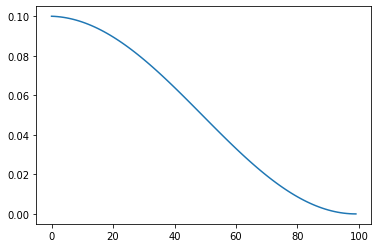

In [ ]:
# Param Scheduler from fvcore
param_sched = CosineParamScheduler(1, 0)
scheduler = LRMultiplier(optim, max_iter=max_steps, multiplier=param_sched)

lr = []

for _ in range(epoch):
    for _ in range(batch_nb):
        optim.step()
        optim.zero_grad()
        scheduler.step()
        lr.append(scheduler.get_lr())

plt.plot(lr);

In [ ]:
# export
def FlatCosScheduler(optimizer: Optimizer, pct_start: float, max_iters: int):
    """
    Schedule the LearningRate at flat `lr` for `pct_start` of `max_iters` before cosine annealing.

    Inspired From - https://docs.fast.ai/callback.schedule.html#Learner.fit_flat_cos.
    """

    schedulers = [LinearParamScheduler(1, 1), CosineParamScheduler(1, 0)]

    sched = CompositeParamScheduler(
        schedulers,
        lengths=[pct_start, 1 - pct_start],
        interval_scaling=["rescaled", "rescaled"],
    )

    # Wrap Param Scheduler under LRMultiplier class
    sched = LRMultiplier(optimizer, sched, max_iter=max_iters)
    return sched

> Note:  `.step` should be called after a batch has been used for training.

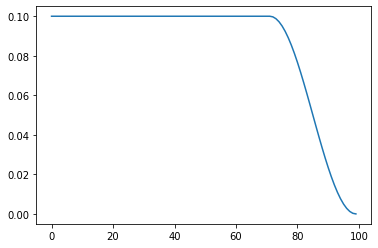

In [ ]:
lr = []

scheduler = FlatCosScheduler(optim, pct_start=0.72, max_iters=max_steps)

for _ in range(epoch):
    for _ in range(batch_nb):
        optim.step()
        optim.zero_grad()
        scheduler.step()
        lr.append(scheduler.get_lr())

plt.plot(lr);

> Tip: You can also set `pct_start=0` for `CosineAnnealing` only.

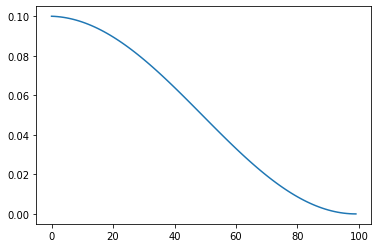

In [ ]:
lr = []

scheduler = FlatCosScheduler(optim, pct_start=0.0, max_iters=max_steps)

for _ in range(epoch):
    for _ in range(batch_nb):
        optim.step()
        optim.zero_grad()
        scheduler.step()
        lr.append(scheduler.get_lr())

plt.plot(lr);

In [ ]:
# export
class WarmupParamScheduler(CompositeParamScheduler):
    """
    Add an initial warmup stage to another scheduler.

    Source - https://github.com/facebookresearch/fvcore/blob/master/fvcore/common/param_scheduler.py
    """

    def __init__(
        self,
        scheduler: ParamScheduler,
        warmup_factor: float,
        warmup_length: float,
        warmup_method: str = "linear",
    ):
        """
        Args:
            scheduler: warmup will be added at the beginning of this scheduler
            warmup_factor: the factor w.r.t the initial value of ``scheduler``, e.g. 0.001
            warmup_length: the relative length (in [0, 1]) of warmup steps w.r.t the entire
                training, e.g. 0.01
            warmup_method: one of "linear" or "constant"
        """
        end_value = scheduler(warmup_length)  # the value to reach when warmup ends
        start_value = warmup_factor * scheduler(0.0)
        if warmup_method == "constant":
            warmup = ConstantParamScheduler(start_value)
        elif warmup_method == "linear":
            warmup = LinearParamScheduler(start_value, end_value)
        else:
            raise ValueError("Unknown warmup method: {}".format(warmup_method))
        super().__init__(
            [warmup, scheduler],
            interval_scaling=["rescaled", "fixed"],
            lengths=[warmup_length, 1 - warmup_length],
        )

In [ ]:
# export
def WarmupCosineLR(
    optimizer: torch.optim.Optimizer,
    max_iters: int,
    pct_start: Optional[float] = None,
    warmup_steps: Optional[int] = None,
):
    """
    Linearly increase `lr` for `pct_start` or `warmup_steps` before cosine annealing from
    `pct_start` or `warmup_steps`.
    """

    # warmup iterations
    if pct_start is None and warmup_steps is None:
        raise ValueError("You must define either pct_start OR warmup_steps")

    if warmup_steps is not None and (
        warmup_steps <= 0 or not isinstance(warmup_steps, int)
    ):
        raise ValueError(
            "Expected positive interger warmup_steps, but got {}".format(warmup_steps)
        )
    if pct_start is not None and (pct_start <= 0 and not isinstance(pct_start, float)):
        raise ValueError(
            "Expected positive float pct_start, but got {}".format(pct_start)
        )

    if pct_start is not None:
        warmup_length = pct_start

    elif warmup_steps is not None:
        warmup_length = warmup_steps / max_iters

    sched = CosineParamScheduler(1, 0)

    sched = WarmupParamScheduler(
        sched,
        warmup_factor=(1.0 / 1000),
        warmup_length=warmup_length,
        warmup_method="linear",
    )
    return LRMultiplier(optimizer, multiplier=sched, max_iter=max_iters)

Arguments to `WarmupCosineLR` -  
* `optimizer` (Optimizer): Wrapped Optimizer.
* `max_iters` (int): The total number of steps to train for.
* `pct_start` (float): The percentage of steps spent increasing the learning rate. Default: None
* `warmup_steps` (int): The no. of steps spent increasing the learning rate. Default: None

> Note: You must either provide `pct_start` or `warmup_steps` & `.step` should be called after a batch has been used for training.

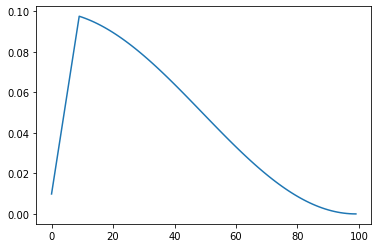

In [ ]:
lr = []

scheduler = WarmupCosineLR(optim, pct_start=0.1, max_iters=max_steps)

for _ in range(epoch):
    for _ in range(batch_nb):
        optim.step()
        scheduler.step()
        lr.append(scheduler.get_lr())

plt.plot(lr);

In [ ]:
# export
def WarmupLinearLR(
    optimizer: Optimizer,
    max_iters: int,
    pct_start: Optional[float] = None,
    warmup_steps: Optional[int] = None,
):
    """
    Linearly increase `lr` for `pct_start` or `warmup_steps` before
    linear decreasing of `lr`.
    """
    # warmup iterations
    if pct_start is None and warmup_steps is None:
        raise ValueError("You must define either pct_start OR warmup_steps")

    if warmup_steps is not None and (
        warmup_steps <= 0 or not isinstance(warmup_steps, int)
    ):
        raise ValueError(
            "Expected positive interger warmup_steps, but got {}".format(warmup_steps)
        )
    if pct_start is not None and (pct_start <= 0 and not isinstance(pct_start, float)):
        raise ValueError(
            "Expected positive float pct_start, but got {}".format(pct_start)
        )

    if pct_start is not None:
        warmup_length = pct_start

    elif warmup_steps is not None:
        warmup_length = warmup_steps / max_iters

    sched = LinearParamScheduler(1, 0)
    sched = WarmupParamScheduler(
        sched,
        warmup_factor=(1.0 / 1000),
        warmup_length=warmup_length,
        warmup_method="linear",
    )
    return LRMultiplier(optimizer, multiplier=sched, max_iter=max_iters)

Arguments to `WarmupLinearLR` -  
* `optimizer` (Optimizer): Wrapped Optimizer.
* `max_iters` (int): The total number of steps to train for.
* `pct_start` (float): The percentage of steps spent increasing the learning rate. Default: None
* `warmup_steps` (int): The no. of steps spent increasing the learning rate. Default: None

> Note: You must either provide `pct_start` or `warmup_steps` & `.step` should be called after a batch has been used for training.

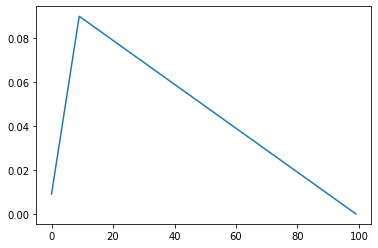

In [ ]:
lr = []

scheduler = WarmupLinearLR(optim, pct_start=0.1, max_iters=max_steps)

for _ in range(epoch):
    for _ in range(batch_nb):
        optim.step()
        scheduler.step()
        lr.append(scheduler.get_lr())

plt.plot(lr);

In [ ]:
# export
def WarmupConstantLR(
    optimizer: Optimizer,
    max_iters: int,
    pct_start: Optional[float] = None,
    warmup_steps: Optional[int] = None,
):
    """
    Linearly increase `lr` for `pct_start` or `warmup_steps` after
    which keep the `lr` at constant value.
    """
    # warmup iterations
    if pct_start is None and warmup_steps is None:
        raise ValueError("You must define either pct_start OR warmup_steps")

    if warmup_steps is not None and (
        warmup_steps <= 0 or not isinstance(warmup_steps, int)
    ):
        raise ValueError(
            "Expected positive interger warmup_steps, but got {}".format(warmup_steps)
        )
    if pct_start is not None and (pct_start <= 0 and not isinstance(pct_start, float)):
        raise ValueError(
            "Expected positive float pct_start, but got {}".format(pct_start)
        )

    if pct_start is not None:
        warmup_length = pct_start

    elif warmup_steps is not None:
        warmup_length = warmup_steps / max_iters

    sched = LinearParamScheduler(1, 1)
    sched = WarmupParamScheduler(
        sched,
        warmup_factor=(1.0 / 1000),
        warmup_length=warmup_length,
        warmup_method="linear",
    )
    return LRMultiplier(optimizer, multiplier=sched, max_iter=max_iters)

Arguments to `WarmupConstantLR` -  
* `optimizer` (Optimizer): Wrapped Optimizer.
* `max_iters` (int): The total number of steps to train for.
* `pct_start` (float): The percentage of steps spent increasing the learning rate. Default: None
* `warmup_steps` (int): The no. of steps spent increasing the learning rate. Default: None

> Note: You must either provide `pct_start` or `warmup_steps` & `.step` should be called after a batch has been used for training.

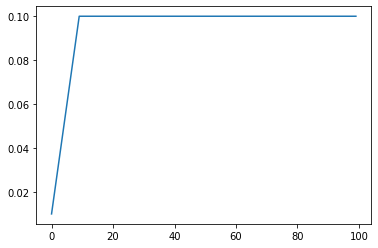

In [ ]:
lr = []

scheduler = WarmupConstantLR(optim, pct_start=0.1, max_iters=max_steps)

for _ in range(epoch):
    for _ in range(batch_nb):
        optim.step()
        scheduler.step()
        lr.append(scheduler.get_lr())

plt.plot(lr);

# Export -

In [ ]:
# hide
notebook2script()

Converted 00_core.logging.ipynb.
Converted 00a_core.structures.ipynb.
Converted 00b_core.visualize.ipynb.
Converted 01_core.nn.utils.ipynb.
Converted 01a_core.nn.losses.ipynb.
Converted 01b_core.nn.optim.optimizers.ipynb.
Converted 01c_core.nn.optim.lr_schedulers.ipynb.
Converted 03_collections.pandas.ipynb.
